In [1]:
import numpy as np # --- Process Data ---

def scrapetle():
    import urllib2

    data = urllib2.urlopen("http://celestrak.com/NORAD/elements/stations.txt").read(168) # read only 20 000 chars
    lines = data.split("\n") # then split it into lines

    #for line in lines:
    #    print line
    return (lines)

def scrapetle2():
    import requests
    from bs4 import BeautifulSoup
    url = 'http://celestrak.com/NORAD/elements/stations.txt'
    response = requests.get(url)
    html = response.content
    soup = BeautifulSoup(html, "lxml")
    mytle=(soup.text[:168])
    print (mytle)
    print ("was printing tle")
    lines = mytle.splitlines
    dir (mytle)
    print ("now printing line 1")

    print (lines(0))
    return (lines)


def getorbit(mydatestr,npoints):
    npoints=npoints
    lonarr=[0] * npoints
    latarr=[0] * npoints
    from datetime import datetime, timedelta
    import sys, os
    import pytz
    from dateutil.parser import parse
    import ephem
    import math
    mydate=parse(mydatestr)
    
    lines=scrapetle()
    iss = ephem.readtle(lines[0], lines[1], lines[2])

    for i in range(0,npoints):
        one_hour = timedelta(hours=1)
        # http://spaceflight.nasa.gov/realdata/sightings/SSapplications/Post/JavaSSOP/orbit/ISS/SVPOST.html
        
        orbitinminutes=24*60/iss._n
        minint = timedelta(minutes=orbitinminutes/npoints)
        dateinc=mydate +i*minint
        home = ephem.Observer()
        home.date = dateinc
        # Always get the latest ISS TLE data from:
        
        degrees_per_radian = 180.0 / math.pi       
        iss.compute(home)
        dist=2
        lonarr[i]=iss.sublong* degrees_per_radian
        latarr[i]=iss.sublat* degrees_per_radian
    return (lonarr, latarr)



def readvaisala (fname):
    data_file = open(fname)
    lats, lons = [], []
    magnitudes = []
    timestrings = []
    datestrings = []
    for index, line in enumerate(data_file.readlines()):
        if index > 0:
            datestrings.append((line.split(' ')[0]))
            timestrings.append((line.split(' ')[1]))
            lats.append(float(line.split(' ')[2]))
            lons.append(float(line.split(' ')[3]))
            magnitudes.append(float(line.split(' ')[4]))
    return datestrings, timestrings, lats, lons, magnitudes


   




 


def get_marker_color(magnitude):
    if np.abs(magnitude) < 200.0:
        return ('go')
    elif np.abs(magnitude) < 400.0:         
        return ('yo')     
    else:         
        return ('ro') 
    


        
%matplotlib inline

def plotvaisala (datestrings, timestrings, lats, lons, magnitudes, tbeg, tend, filtag):
    from mpl_toolkits.basemap import Basemap
    import matplotlib.pyplot as plt
    import numpy as np
    
    npoints=93
    import pytz
    utc_dt = datestrings[0].astimezone (pytz.utc)
    firstflashtimestr=utc_dt.isoformat()
    mydate=getantimeridiancrossingtime2(firstflashtimestr)
    utc_dt2 = mydate.astimezone (pytz.utc)

    mydatestr=utc_dt2.isoformat()
    
    lonarr, latarr=getorbit(mydatestr, npoints)
    print ("Creating plot of ground lightning data ... please wait")
    fig=plt.figure( figsize=(15, 6))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])

    minlat= (min (lats))
    maxlat= (max (lats))
    minlon= (min (lons))
    maxlon= (max (lons))
    
    
    minlat= -60
    maxlat= 60
    minlon= -179
    maxlon= 179
    
    minmag=(min (magnitudes))
    maxmag=(max (magnitudes))     
    # --- Build Map ---


    map =  Basemap(projection='merc',llcrnrlat=minlat,urcrnrlat=maxlat,\
                llcrnrlon=minlon,urcrnrlon=maxlon,lat_ts=20,resolution='c')
    map.drawcoastlines()
    map.drawcountries()
    #map.fillcontinents(color = 'gray')
    map.drawmapboundary()
    map.drawmeridians(np.arange(0, 360, 30),labels=[0,0,0,1],fontsize=10)
    map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0],fontsize=10)
    date = datetime.utcnow()
    date=datestrings[0]

    import pytz
    utc_dt = date.astimezone (pytz.utc)
    utc_dt = utc_dt.replace(tzinfo=None)
    CS=map.nightshade(utc_dt)

    min_marker_size = .09
    for lon, lat, mag in zip(lons, lats, magnitudes):
        x,y = map(lon, lat)
        msize = mag * min_marker_size
        marker_string = get_marker_color(mag)
        map.plot(x, y, marker_string, markersize=msize)

    x, y = map(lonarr, latarr) # forgot this line 
    map.plot(x, y, 'D-', markersize=4, linewidth=2, color='k', markerfacecolor='b') 
    plt.title("Vaisala GLD 360 data  from "+ tbeg 
              + ' to  '  + tend +' ,  nevents=' + str(len(datestrings)))
    tag = datestrings[0].strftime('%Y%m%dT%H%M%S')
    plt.savefig('vaisala'+filtag+tag+'.png')

    plt.show()

    
def getantimeridiancrossingtime2(timestr):
    import math
    import time
    from datetime import datetime, timedelta
    import ephem
    import numpy as np
    import sys, os
    import pytz
    from dateutil.parser import parse
    
    mydatenow=parse(timestr)
    home = ephem.Observer()
    home.date=mydatenow
    delta_min=timedelta(minutes=1)
    radtodeg=180/np.pi

    lines=scrapetle()
    # http://spaceflight.nasa.gov/realdata/sightings/SSapplications/Post/JavaSSOP/orbit/ISS/SVPOST.html
    iss = ephem.readtle(lines[0], lines[1], lines[2])
    
    angle=+178
    angleold=179
    i=0
    while angle < angleold:        
    #for i in range(0,10):
        i=i+1
        mydatenow=parse(timestr)-delta_min*i
        #print (mydatenow)
        angleold=angle+0.0
        home.date=mydatenow
        timeold=mydatenow+timedelta(minutes=1)
        iss.compute(home)        
        angle=iss.sublong*radtodeg
        
        #print mydatenow, angle, angleold
    print ("antimeridian",angleold)
    return (timeold)




def getantimeridiancrossingtime(timestr):
    import math
    import time
    from datetime import datetime, timedelta
    import ephem
    import numpy as np
    import sys, os
    import pytz
    from dateutil.parser import parse
    #mydate=datetime(2016, 4, 7, 9, 10, 45)
    mydatenow=parse(timestr)
    home = ephem.Observer()
    home.date=mydatenow
    lines=scrapetle()
    # http://spaceflight.nasa.gov/realdata/sightings/SSapplications/Post/JavaSSOP/orbit/ISS/SVPOST.html
    iss = ephem.readtle(lines[0], lines[1], lines[2])
    degrees_per_radian = 180.0 / math.pi    
    iss.compute(home)

    issorbitsperday=iss._n
    issorbitalperiod=24*60/issorbitsperday


    #print ("ISS sublong" , iss.sublong)
    sublong=iss.sublong.real

    #print ("Position in degrees", sublong*180/np.pi)

    radtodeg=180/np.pi

    angletoam=(sublong+np.pi)
    angletoamdeg=angletoam*radtodeg
    #print ("Angle to AM in degrees", angletoam*radtodeg)
    timetoam=(angletoamdeg)*issorbitalperiod/360


    deltatoam=timedelta(minutes=timetoam)
    mydate=mydatenow-deltatoam


    #print ("Minutes to antimeridian" , timetoam)

    #print ("time Delta to antimeridian" , deltatoam)
    print ("Time ", mydatenow)

    print ("Antimeridian time", mydate)
    home.date = mydate
    iss.compute(home)
            
    print ("antimeridian estimate", iss.sublong*radtodeg)
    return (mydate)



def filtervaisala(datestrings, timestrings, lats, lons, magnitudes):
    lines=scrapetle()
    # http://spaceflight.nasa.gov/realdata/sightings/SSapplications/Post/JavaSSOP/orbit/ISS/SVPOST.html
    import ephem
    import math
    iss = ephem.readtle(lines[0], lines[1], lines[2])

    count=0
    degrees_per_radian = 180.0 / math.pi

    fildate=[]
    filtime=[]
    fillat=[]
    fillon=[]
    filmag=[]
    for i in range (0,datestrings.size):
        iss.compute(datestrings[i])
        distlat=iss.sublat*degrees_per_radian-lats[i]
        distlon=iss.sublong*degrees_per_radian-lons[i]

        asimbox=8

        #print (np.abs(distlat),(np.abs(distlon)) )
        if ( (np.abs(distlat) < asimbox) and (np.abs(distlon) < asimbox)): 
            #print (np.abs(distlat),(np.abs(distlon)) , datestrings[i])
            #print (lats[i], lons[i], iss.sublat, iss.sublong)
            count=count+1

            #print ("yes", i, count)
            filmag.append(magnitudes[i])
            fillon.append(lons[i])
            fillat.append(lats[i])
            fildate.append(datestrings[i])
            filtime.append(timestrings[i])
    print (count)   
    return (fildate, filtime, fillat, fillon, filmag)


def read_postgres_vaisala (tbeg, tend, limit):
    import psycopg2
    import sys
    import numpy as np


    con = None

    try:

        con = psycopg2.connect(host='asdc.space.dtu.dk', database='gld', user='gmurphy', password='j-l%CHB2Za') 
        cur = con.cursor()
        cur.execute("SET TIME ZONE 'UTC';")  # UTC 
        cur.execute("SELECT * FROM lightnings LIMIT 0")
        colnames = [desc[0] for desc in cur.description]
        cur.execute("SELECT * FROM lightnings WHERE ltime   BETWEEN '"+tbeg+"' AND '"+tend+"' ORDER BY ltime ASC, ltime_ns  LIMIT '"+limit+"' ;")          
        data =   (cur.fetchall())

        #for row in rows:
        #    print (row)

    except :
        print ('Error could not connect to database'     )
        sys.exit(1)


    finally:

        if con:
            con.close()


    from numpy import array
    nparr = array( data )
    print ('npar.shape' ,nparr.shape)
    #id=nparr[:,0]
    datestrings=nparr[:,0]
    timestrings=nparr[:,1].astype(int)
    magnitudes=nparr[:,2].astype(float)
    lats=nparr[:,3].astype(float)
    lons=nparr[:,4].astype(float)
    
    return datestrings, timestrings, lats, lons, magnitudes




def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

Fetching data from asdc 2016-07-07 14:55:05.878881
('npar.shape', (4000, 5))
Time to fetch 0:00:26.967835
('antimeridian', -178.11750925105244)
Creating plot of ground lightning data ... please wait


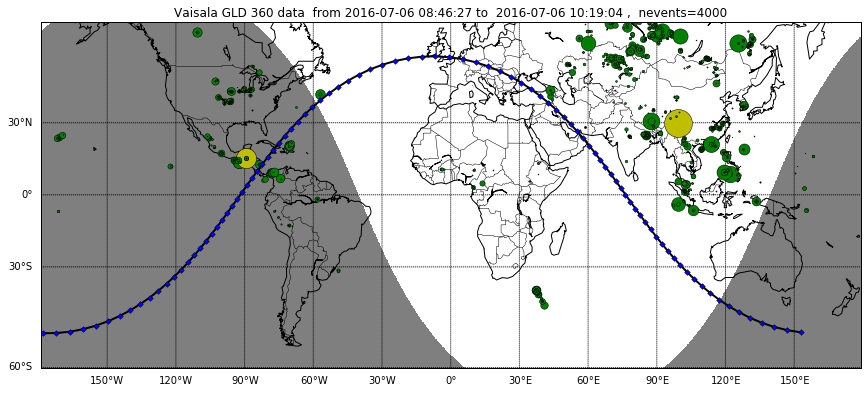

('npar.shape', (397374, 5))
429
('antimeridian', -177.71795684498503)
Creating plot of ground lightning data ... please wait


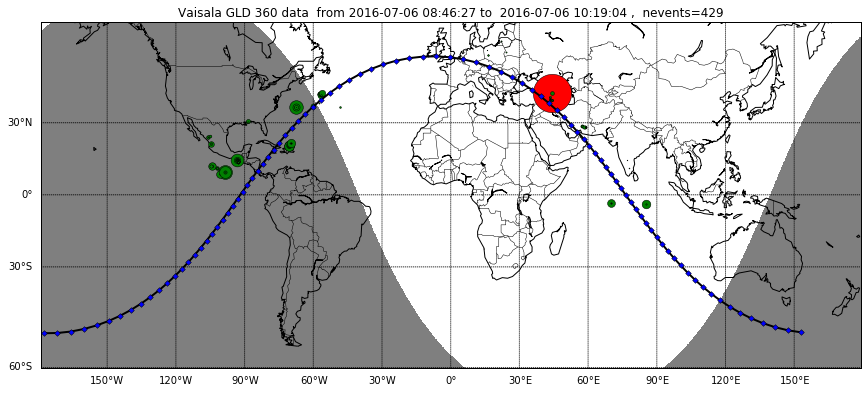

Time to plot 0:01:33.865328
Fetching data from asdc 2016-07-07 14:57:06.712097
('npar.shape', (4000, 5))
Time to fetch 0:00:26.678937
('antimeridian', -178.0290992824358)
Creating plot of ground lightning data ... please wait


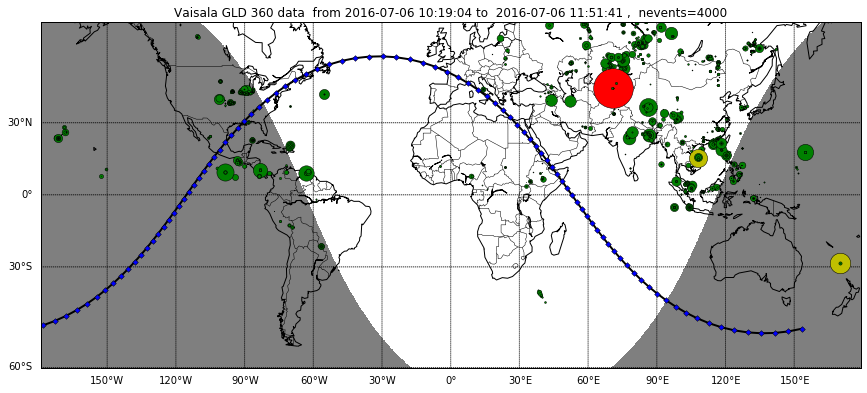

('npar.shape', (380909, 5))
1946
('antimeridian', -176.67769171363543)
Creating plot of ground lightning data ... please wait


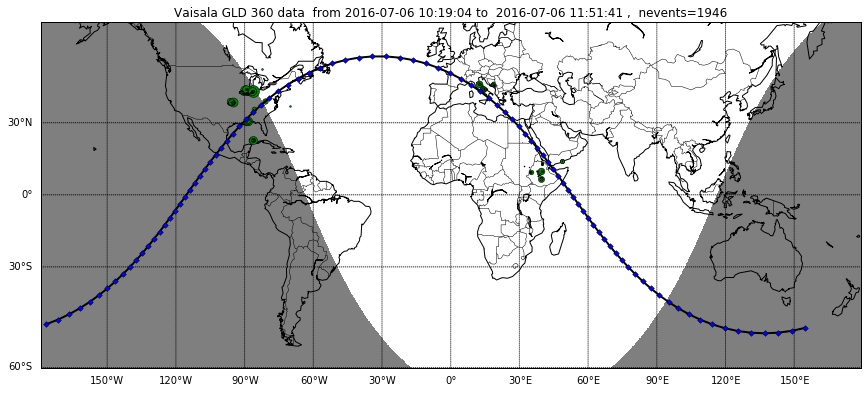

Time to plot 0:01:32.111831
Fetching data from asdc 2016-07-07 14:59:05.503055
('npar.shape', (4000, 5))
Time to fetch 0:00:25.394048
('antimeridian', -177.88408070597808)
Creating plot of ground lightning data ... please wait


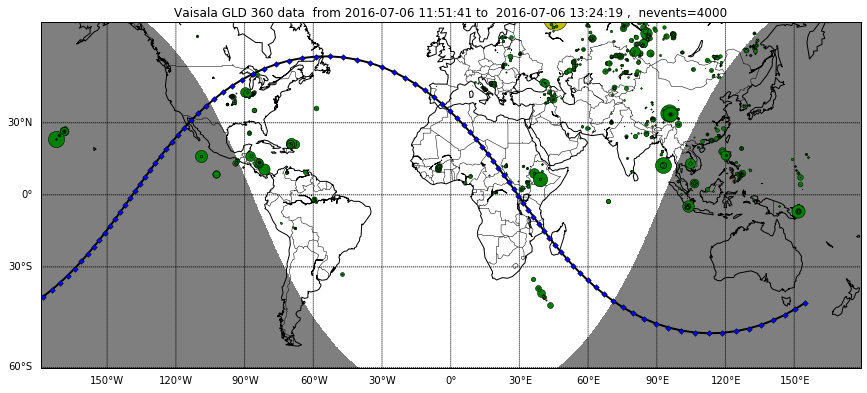

('npar.shape', (381548, 5))
3237
('antimeridian', -179.00596659790935)
Creating plot of ground lightning data ... please wait


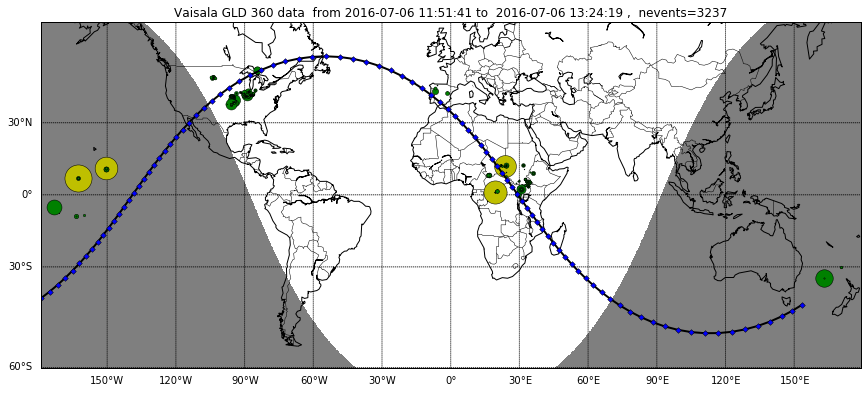

Time to plot 0:01:37.555839
Fetching data from asdc 2016-07-07 15:01:08.453015
('npar.shape', (4000, 5))
Time to fetch 0:00:29.084467
('antimeridian', -179.2211312171431)
Creating plot of ground lightning data ... please wait


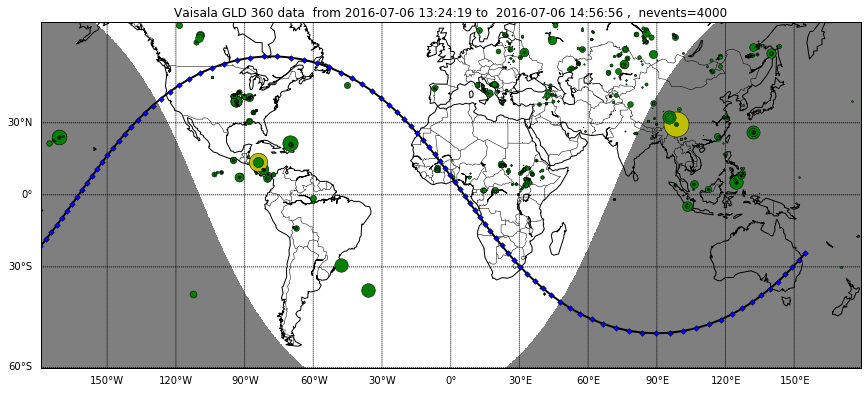

('npar.shape', (428282, 5))
420
('antimeridian', -178.2929221693167)
Creating plot of ground lightning data ... please wait


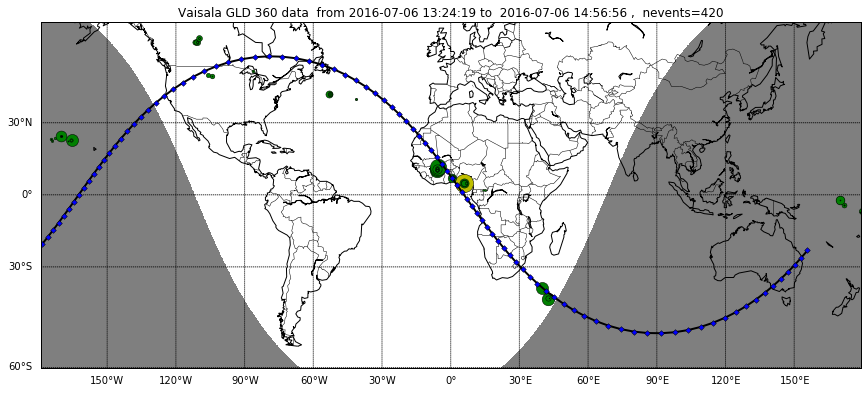

Time to plot 0:01:32.680107
Fetching data from asdc 2016-07-07 15:03:10.217652
('npar.shape', (4000, 5))
Time to fetch 0:00:26.579833
('antimeridian', -177.79991911502518)
Creating plot of ground lightning data ... please wait


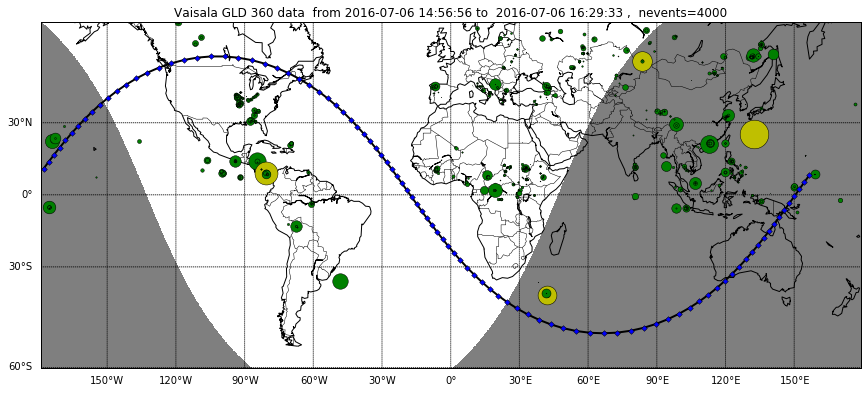

('npar.shape', (431402, 5))
123
('antimeridian', -179.59138211167115)
Creating plot of ground lightning data ... please wait


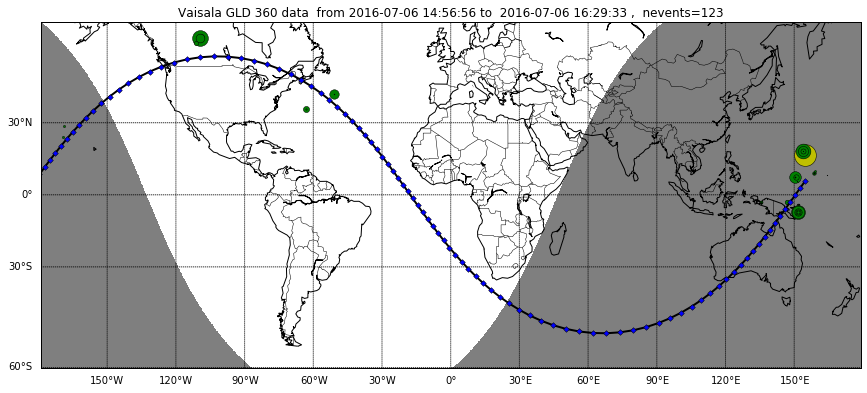

Time to plot 0:01:35.203008
Fetching data from asdc 2016-07-07 15:05:12.000572
('npar.shape', (4000, 5))
Time to fetch 0:00:27.306758
('antimeridian', -178.66210755433423)
Creating plot of ground lightning data ... please wait


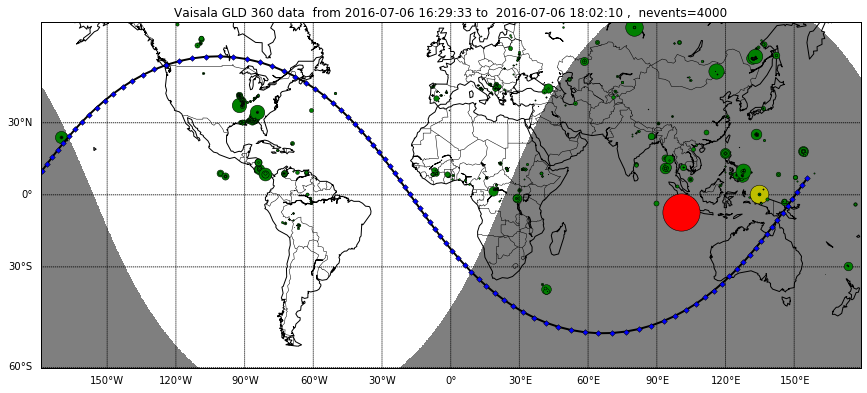

('npar.shape', (408123, 5))
4310
('antimeridian', -178.2619267708632)
Creating plot of ground lightning data ... please wait


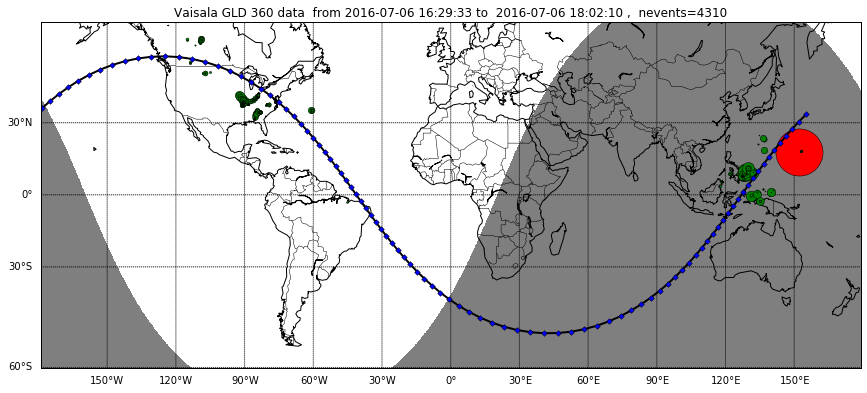

Time to plot 0:01:41.816034
Fetching data from asdc 2016-07-07 15:07:21.123420
('npar.shape', (4000, 5))
Time to fetch 0:00:26.398440
('antimeridian', -177.80766454954397)
Creating plot of ground lightning data ... please wait


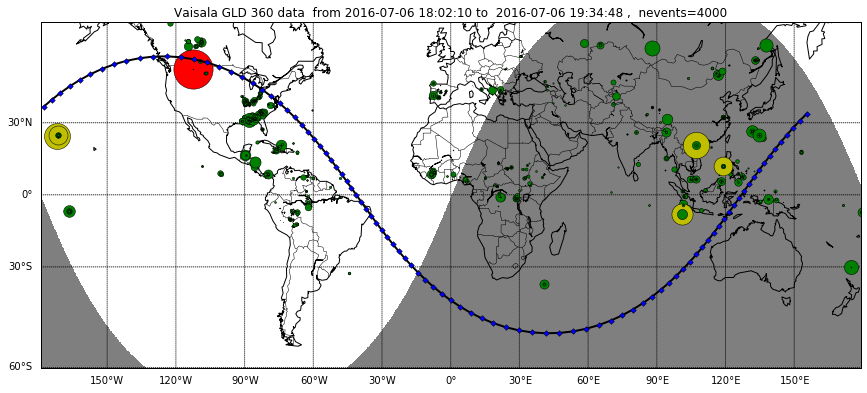

('npar.shape', (441279, 5))
9257
('antimeridian', -177.80766454954397)
Creating plot of ground lightning data ... please wait


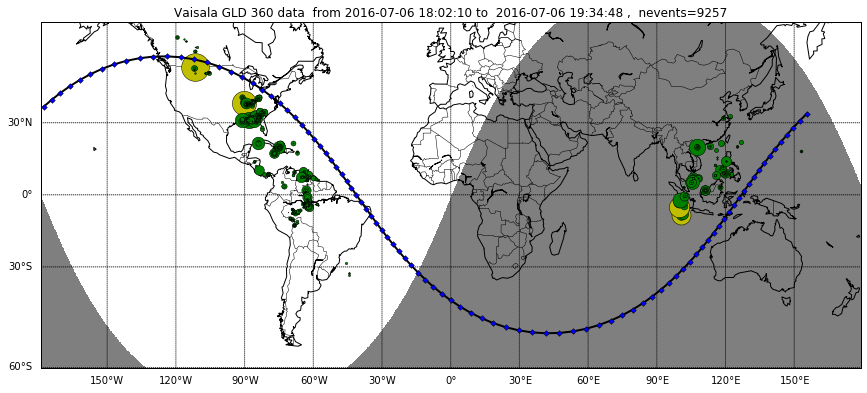

Time to plot 0:02:22.943466
Fetching data from asdc 2016-07-07 15:10:10.465385
('npar.shape', (4000, 5))
Time to fetch 0:00:29.109904
('antimeridian', -175.43905056803194)
Creating plot of ground lightning data ... please wait


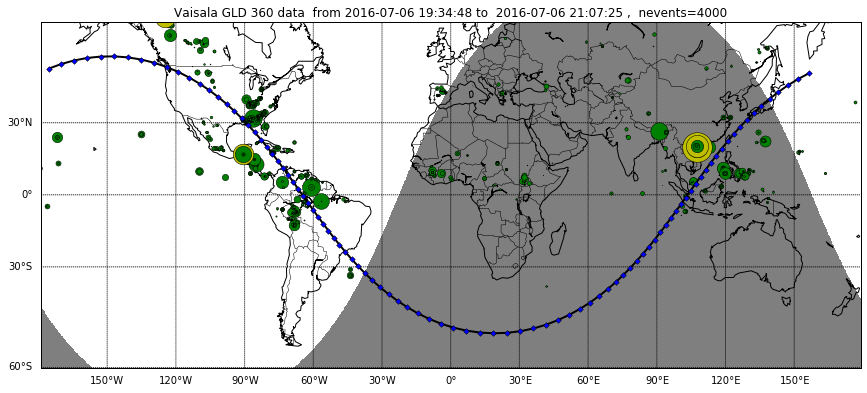

('npar.shape', (428872, 5))
1686
('antimeridian', -175.43905056803194)
Creating plot of ground lightning data ... please wait


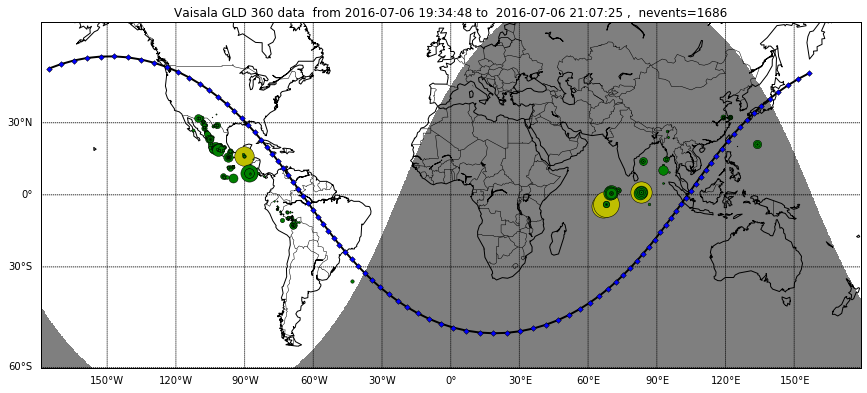

Time to plot 0:01:35.679772
Fetching data from asdc 2016-07-07 15:12:15.255162
('npar.shape', (4000, 5))
Time to fetch 0:00:26.425838
('antimeridian', -175.91215045108206)
Creating plot of ground lightning data ... please wait


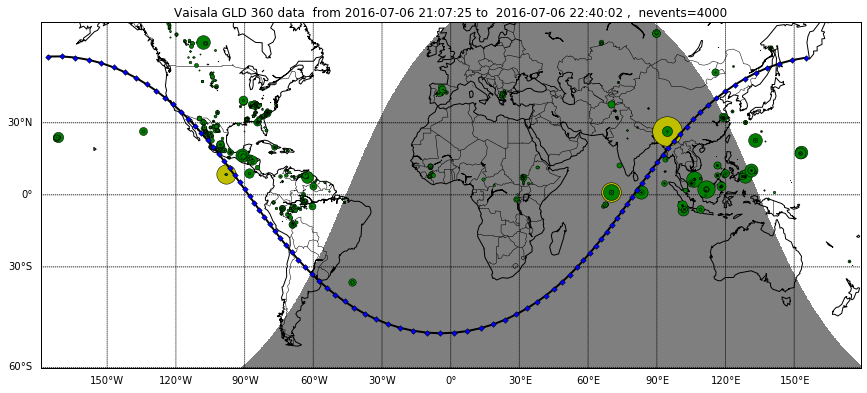

('npar.shape', (411587, 5))
596
('antimeridian', -175.2110861742936)
Creating plot of ground lightning data ... please wait


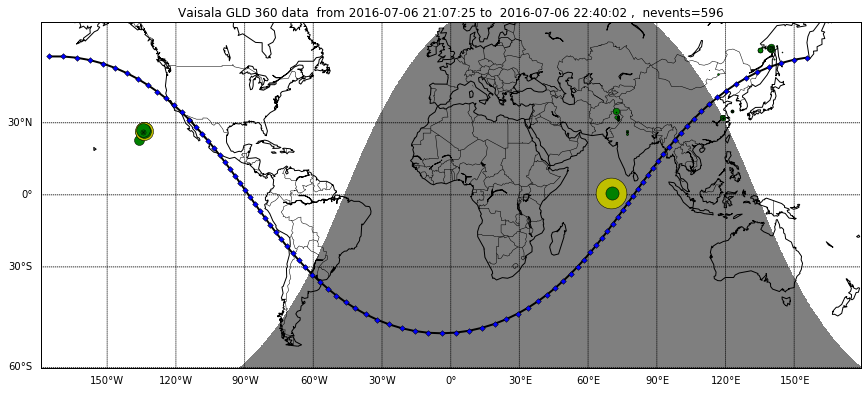

Time to plot 0:01:31.416556
Fetching data from asdc 2016-07-07 15:14:13.097623
('npar.shape', (4000, 5))
Time to fetch 0:00:27.965621
('antimeridian', -175.61734582612596)
Creating plot of ground lightning data ... please wait


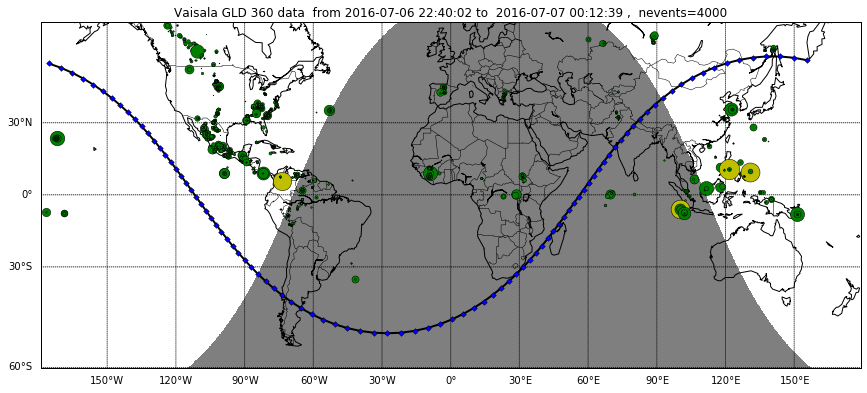

('npar.shape', (382959, 5))
841
('antimeridian', -175.61734582612596)
Creating plot of ground lightning data ... please wait


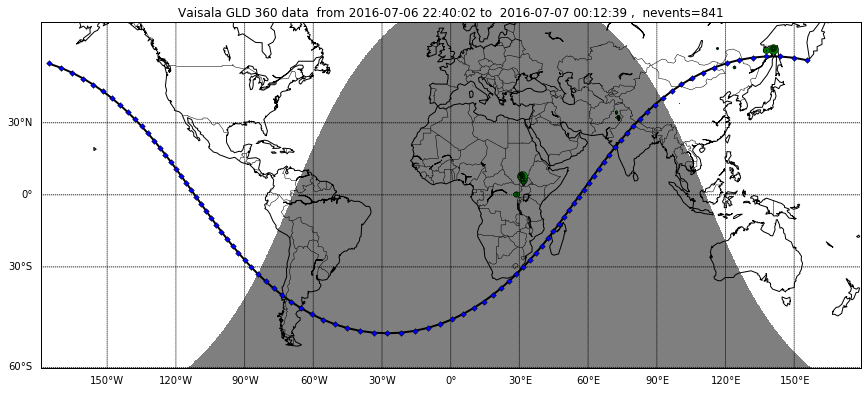

Time to plot 0:02:20.413191
Fetching data from asdc 2016-07-07 15:17:01.476489
('npar.shape', (4000, 5))
Time to fetch 0:00:26.050645
('antimeridian', -179.21050344279456)
Creating plot of ground lightning data ... please wait


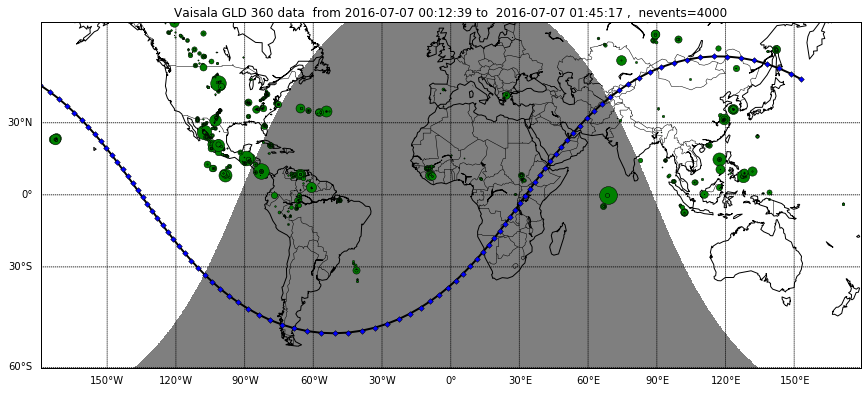

('npar.shape', (369270, 5))
723
('antimeridian', -176.62675216280545)
Creating plot of ground lightning data ... please wait


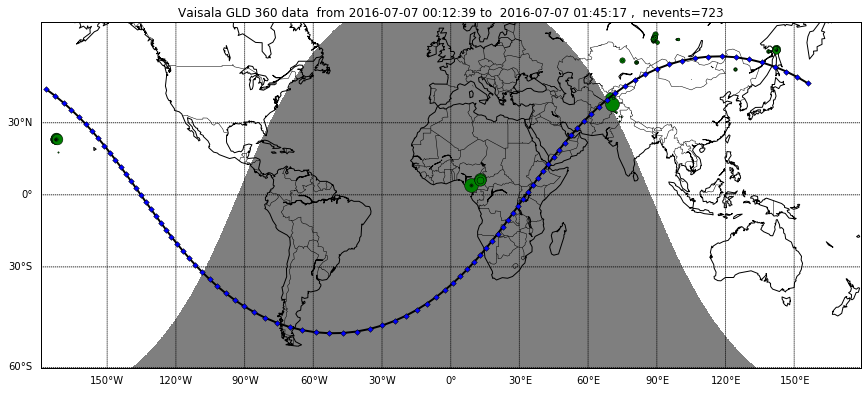

Time to plot 0:01:30.181113
Fetching data from asdc 2016-07-07 15:18:57.708362
('npar.shape', (4000, 5))
Time to fetch 0:00:26.139350
('antimeridian', -178.73576431434364)
Creating plot of ground lightning data ... please wait


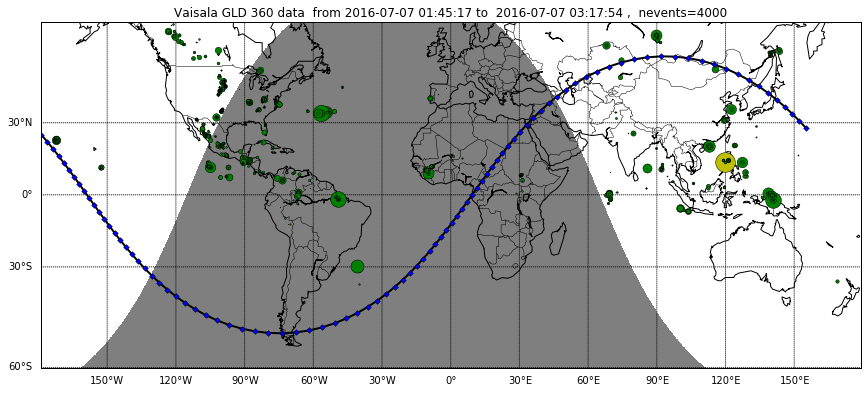

('npar.shape', (319582, 5))
360
('antimeridian', -179.1886058563155)
Creating plot of ground lightning data ... please wait


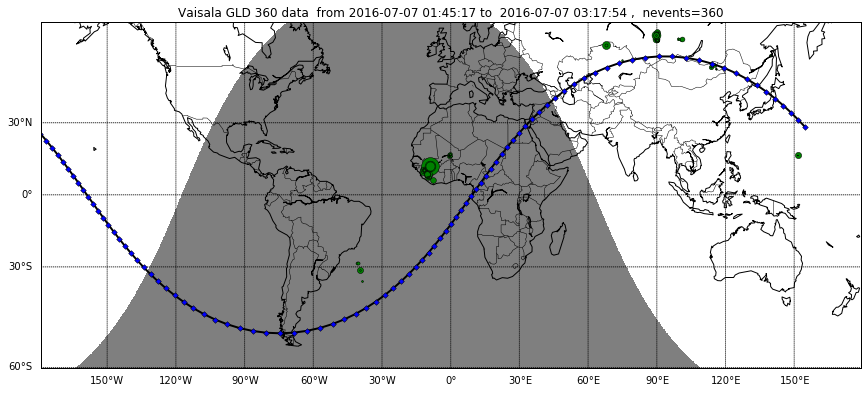

Time to plot 0:01:29.099131
Fetching data from asdc 2016-07-07 15:20:52.946923
('npar.shape', (4000, 5))
Time to fetch 0:00:26.024514
('antimeridian', -179.02776856174003)
Creating plot of ground lightning data ... please wait


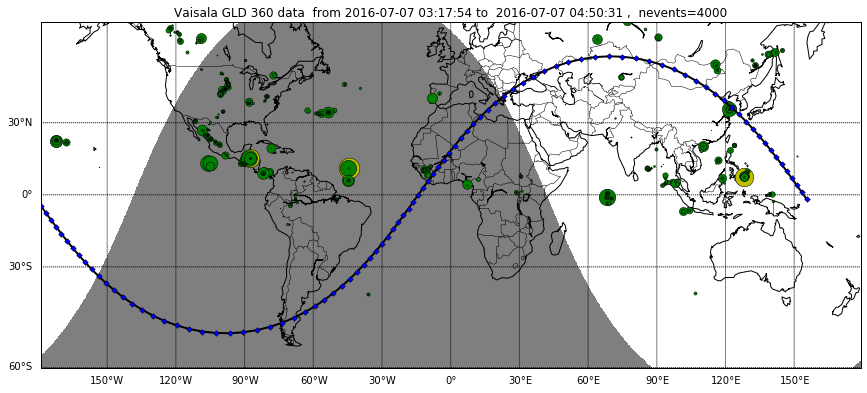

('npar.shape', (295882, 5))
169
('antimeridian', -179.46264670619476)
Creating plot of ground lightning data ... please wait


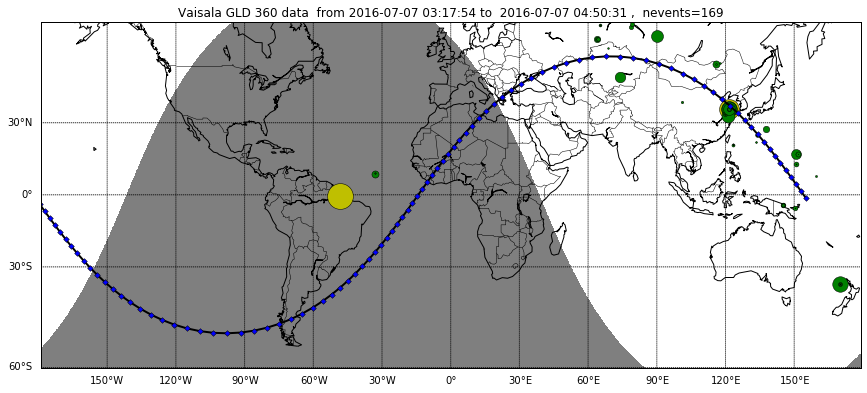

Time to plot 0:01:33.956166
Fetching data from asdc 2016-07-07 15:22:52.927695
('npar.shape', (4000, 5))
Time to fetch 0:00:26.131516
('antimeridian', -176.9258461465603)
Creating plot of ground lightning data ... please wait


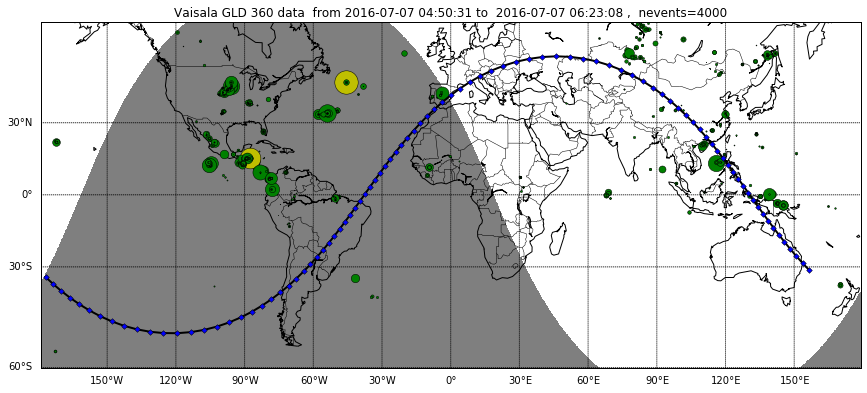

('npar.shape', (338352, 5))
1468
('antimeridian', -178.77666348709369)
Creating plot of ground lightning data ... please wait


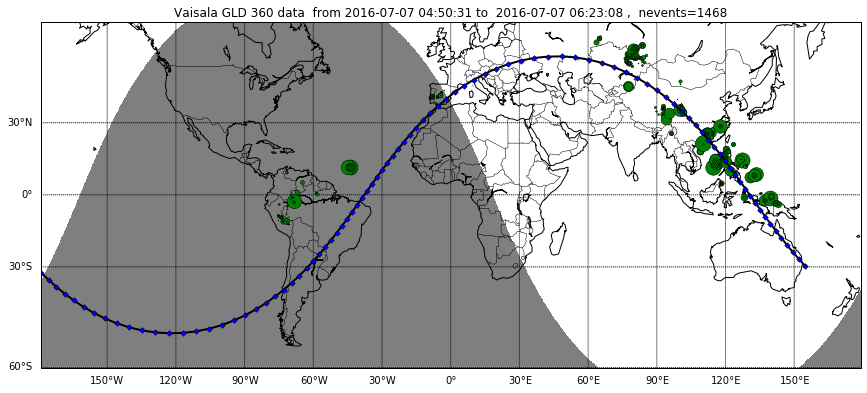

Time to plot 0:01:31.603261
Fetching data from asdc 2016-07-07 15:24:50.662557
('npar.shape', (4000, 5))
Time to fetch 0:00:26.741104
('antimeridian', -176.14432224134913)
Creating plot of ground lightning data ... please wait


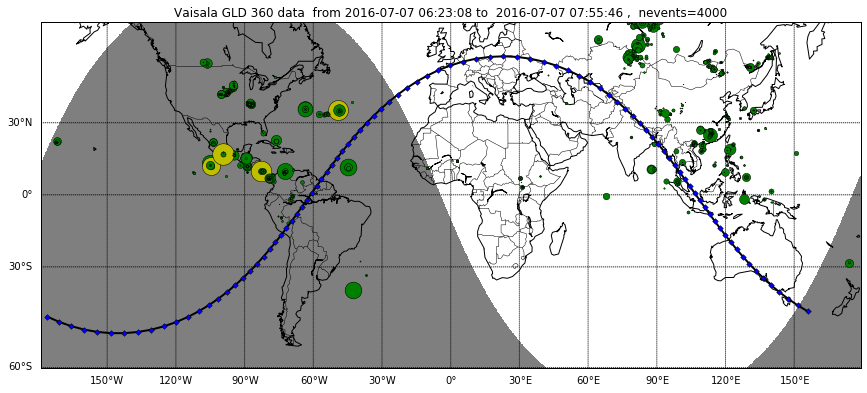

('npar.shape', (457551, 5))
3217
('antimeridian', -175.569821369881)
Creating plot of ground lightning data ... please wait


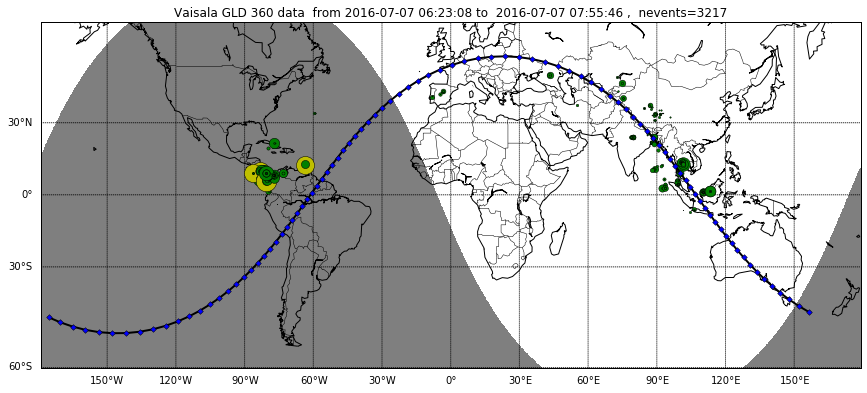

Time to plot 0:01:37.652150
Finished


In [5]:
from __future__ import print_function
   

from datetime import date, datetime, timedelta
import pytz
import ephem
lines=scrapetle()
#print (lines[0]) 
# http://spaceflight.nasa.gov/realdata/sightings/SSapplications/Post/JavaSSOP/orbit/ISS/SVPOST.html
iss = ephem.readtle(lines[0], lines[1], lines[2])
issorbitinminutes=24*60/iss._n
delta=timedelta(minutes=issorbitinminutes)                
start_date = datetime(2016, 7, 6, 8, 46, 27,420000, pytz.UTC)
end_date   = start_date+15*delta
for single_date in perdelta(start_date, end_date, delta):
    #
    a=datetime.utcnow()
    mydate=(single_date.strftime("%Y-%m-%d %t"))
    tbeg=single_date
    tend=tbeg+timedelta(minutes=issorbitinminutes)
    tbegstr=tbeg.strftime("%Y-%m-%d %H:%M:%S")
    tendstr=tend.strftime("%Y-%m-%d %H:%M:%S")
    print ("Fetching data from asdc", str(datetime.now()))
    #
    limitstr=str(4000)
    datestrings, timestrings, lats, lons, magnitudes=read_postgres_vaisala(tbegstr, tendstr, limitstr)
    #datestrings[0]=datestrings[0].astimezone (pytz.utc)
    b=datetime.utcnow()
    print ("Time to fetch",str( b-a))    
    plotvaisala (datestrings, timestrings, lats, lons, magnitudes, tbegstr, tendstr, 'nofil')
    limitstr=str(800000)
    datestrings, timestrings, lats, lons, magnitudes=read_postgres_vaisala(tbegstr, tendstr, limitstr)
    datestrings, timestrings, lats, lons, magnitudes=filtervaisala (datestrings, timestrings, lats, lons, magnitudes)
    nevents=len(datestrings)
    if nevents>0:
        plotvaisala (datestrings, timestrings, lats, lons, magnitudes,tbegstr, tendstr, 'fil')
    c=datetime.utcnow()
    print ("Time to plot",str (c-b))
    
    
    
    
print ("Finished")